# Visualization of the Prediction Rank of the events in the TGBL-wiki dataset.


In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## We start by loading a scoresheet calculated using the code from the TGB benchmark 

The code can be found in https://github.com/shenyangHuang/TGB/blob/main/examples/linkproppred/tgbl-wiki/tgn.py

In [47]:
from datasets import load_dataset
import torch
from stats import collect_edge_statistics, collect_node_statistics

import shared_utils

events, _, _ = load_dataset("wikipedia", data_dir=shared_utils.DATA_PATH).values()

collect_edge_statistics(events)

collect_node_statistics(events)
shared_utils.train_val_test_split_dataframe(events, val_ratio=0.15, test_ratio=0.15)
scores = torch.load("models/tgbl-wiki/tgn_wiki_scores.pt")

wikipedia dataset found, loading it


We calculate for each validation or test event, its score in the list of 1000 events provided in the TGB version of the data

In [48]:
import numpy as np

val_test_size = events.loc["val"].shape[0]  # Val and test are the same size
y_preds = np.zeros((val_test_size, 1000))


def homogenize(preds_list):
    y_preds = np.zeros((len(preds_list), 1000))

    for i, y_i in enumerate(preds_list):
        y_preds[i, 0] = y_i[0]
        y_preds[i, 1 : len(y_i)] = y_i[1:].ravel()
    return y_preds


# len(scores["val"][0])
y_pred_val = homogenize(scores["val"])
y_pred_test = homogenize(scores["test"])

y_pred = np.vstack([y_pred_val, y_pred_test])

events.loc[["val", "test"], "y_pred"] = y_pred[:, 0]
events.loc[["val", "test"], "rank_opt"] = (y_pred[:, 1:] >= y_pred[:, 0, None]).sum(
    axis=1
)
events.loc[["val", "test"], "rank_pes"] = (y_pred[:, 1:] > y_pred[:, 0, None]).sum(
    axis=1
)
events

,src,dst,t,label,idx,edge_key,edge_degree,edge_arrival_rank,src_arrival_rank,dst_arrival_rank,src_degree,dst_degree,t_scaled,y_pred,rank_opt,rank_pes
split,,,,,,,,,,,,,,,,
train,1,8228,0.0,0.0,1,67699985,1.0,0,0,1,1.0,1.0,0.000000,NaN,NaN,NaN
train,2,8229,36.0,0.0,2,67716443,1.0,1,2,3,1.0,1.0,0.000013,NaN,NaN,NaN
train,2,8229,77.0,0.0,3,67716443,2.0,1,2,3,2.0,2.0,0.000029,NaN,NaN,NaN
train,3,8230,131.0,0.0,4,67732903,1.0,2,4,5,1.0,1.0,0.000049,NaN,NaN,NaN
train,2,8229,150.0,0.0,5,67716443,3.0,1,2,3,3.0,3.0,0.000056,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test,2004,8860,2678155.0,0.0,157470,78501604,129.0,3166,2635,2636,217.0,130.0,0.999919,0.999970,4.0,4.0
test,3763,9026,2678158.0,0.0,157471,81472439,226.0,6725,4560,4561,226.0,229.0,0.999920,0.999997,3.0,3.0
test,2400,8723,2678293.0,0.0,157472,76093129,82.0,3946,3077,1655,82.0,208.0,0.999970,0.999714,2.0,2.0


# Prediction Rank on a Temporal Edge Activity Plot

We calculate the Temporal Edge Activity and plot the ranks on it

No handles with labels found to put in legend.


Text(0.5, 0, 'Time')

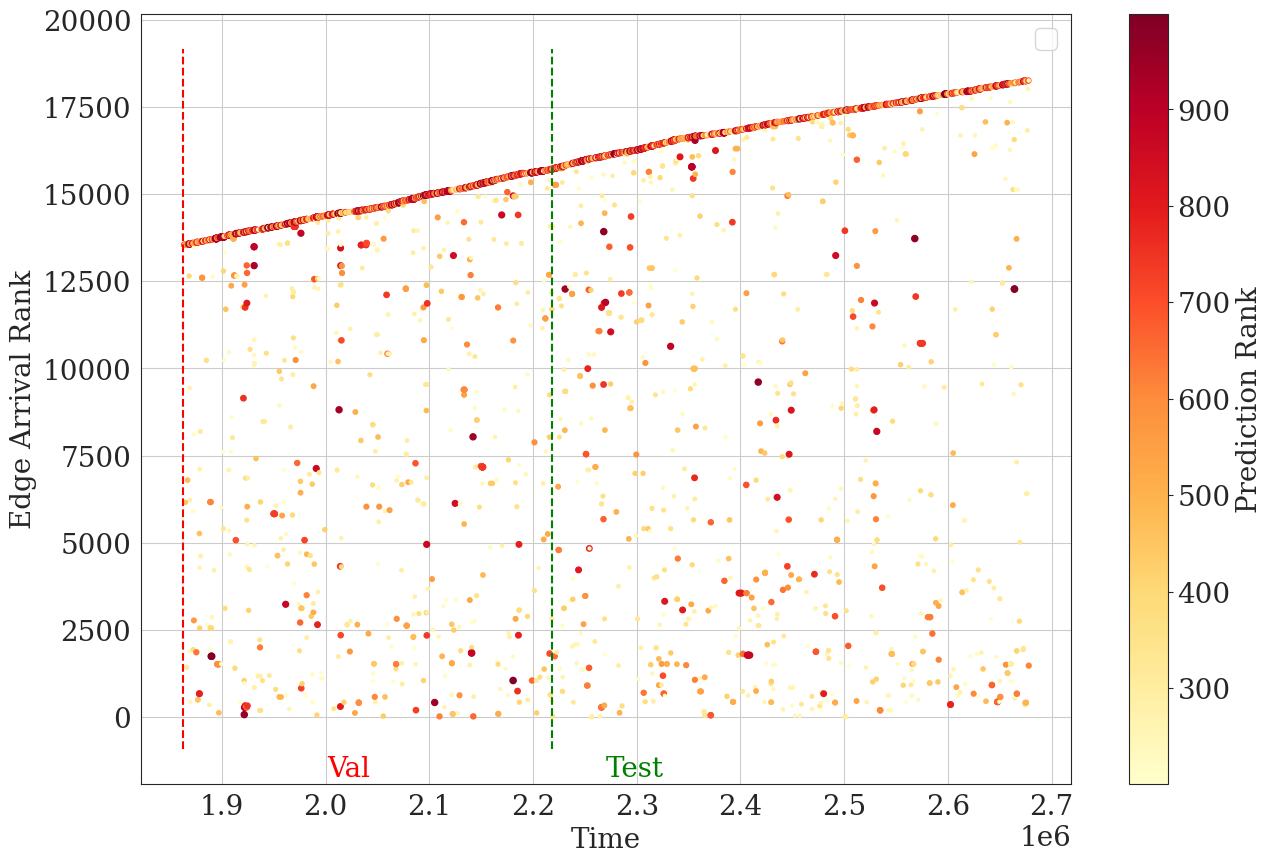

In [46]:
import matplotlib.pyplot as plt

import shared_utils
from pairing import SzudzikPair

from shared_utils import minmaxscale

color_scheme = "YlOrRd"

shared_utils.set_theme(fontsize=20)


fig, axs = plt.subplots(1, figsize=(15, 10))

df = events
df = df[df["rank_opt"] > 200]

im = axs.scatter(
    x=df["t"],
    y=df["edge_arrival_rank"],
    c=df["rank_opt"],
    cmap=color_scheme,
    s=df["rank_opt"] / 50,
)
fig.colorbar(im, ax=axs, label="Prediction Rank")


ylim = plt.ylim()
plt.vlines(
    events.val_time,
    ymin=ylim[0],
    ymax=ylim[1],
    color="red",
    linestyles="dashed",
)


plt.vlines(
    events.test_time,
    ymin=ylim[0],
    ymax=ylim[1],
    color="green",
    linestyles="dashed",
)
ypos = 0.01

plt.annotate(
    "Val",
    xy=(0.2, ypos),
    xytext=(0.2, ypos),
    xycoords="axes fraction",
    fontsize=20,
    color="red",
)
plt.annotate(
    "Test",
    xy=(0.5, ypos),
    xytext=(0.5, ypos),
    xycoords="axes fraction",
    fontsize=20,
    color="green",
)
plt.legend()
plt.ylabel("Edge Arrival Rank")
plt.xlabel("Time")

## Compare the Prediction Rank and the degree of the edge at the time of the event

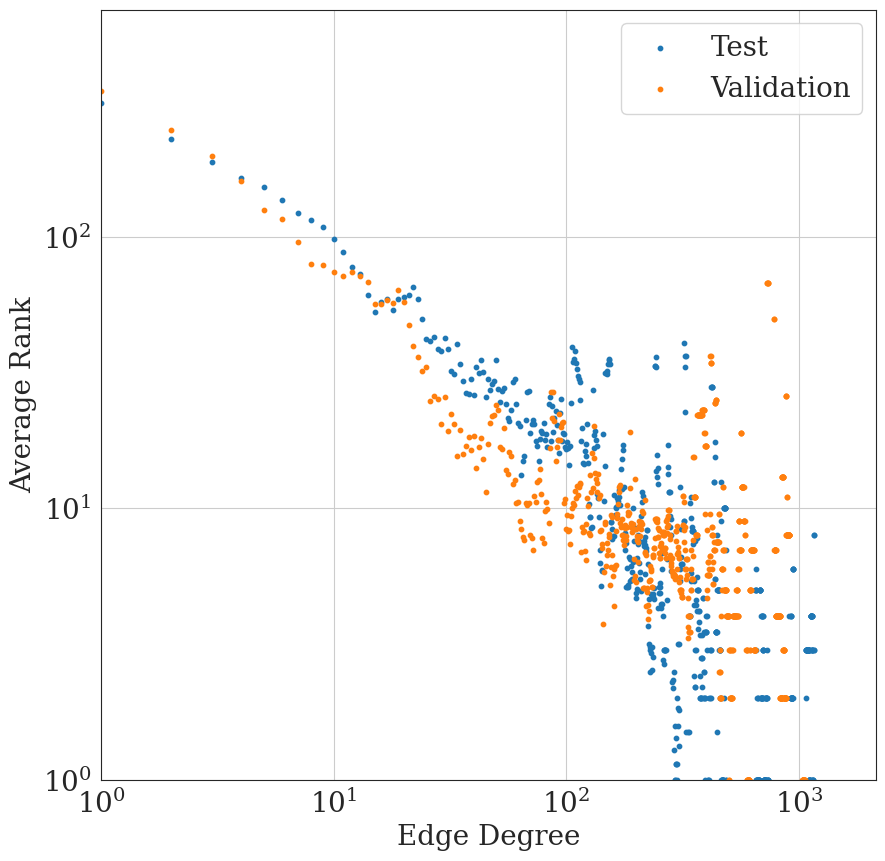

In [49]:
fig, ax = plt.subplots(1, figsize=(10, 10))


def loglogplot(series, ax, *args, **kwargs):
    ax.scatter(series.index.values, series.values, s=10, *args, **kwargs)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(1, series.index.max() * 2)
    ax.set_ylim(1, series.values.max() * 2)


df_valtest = events.loc[["val", "test"]].reset_index()

for name, split in df_valtest.groupby("split"):
    split_ranks = split.groupby("edge_degree")["rank_opt"].mean()

    loglogplot(split_ranks, ax, label=name)
    ax.set_xlabel("Edge Degree")
    ax.set_ylabel("Average Rank")


plt.legend(labels=["Test", "Validation"])

# Visualization of the Rank on a Temporal Node Activity plot

No handles with labels found to put in legend.


Text(0, 0.5, 'Node Arrival Rank')

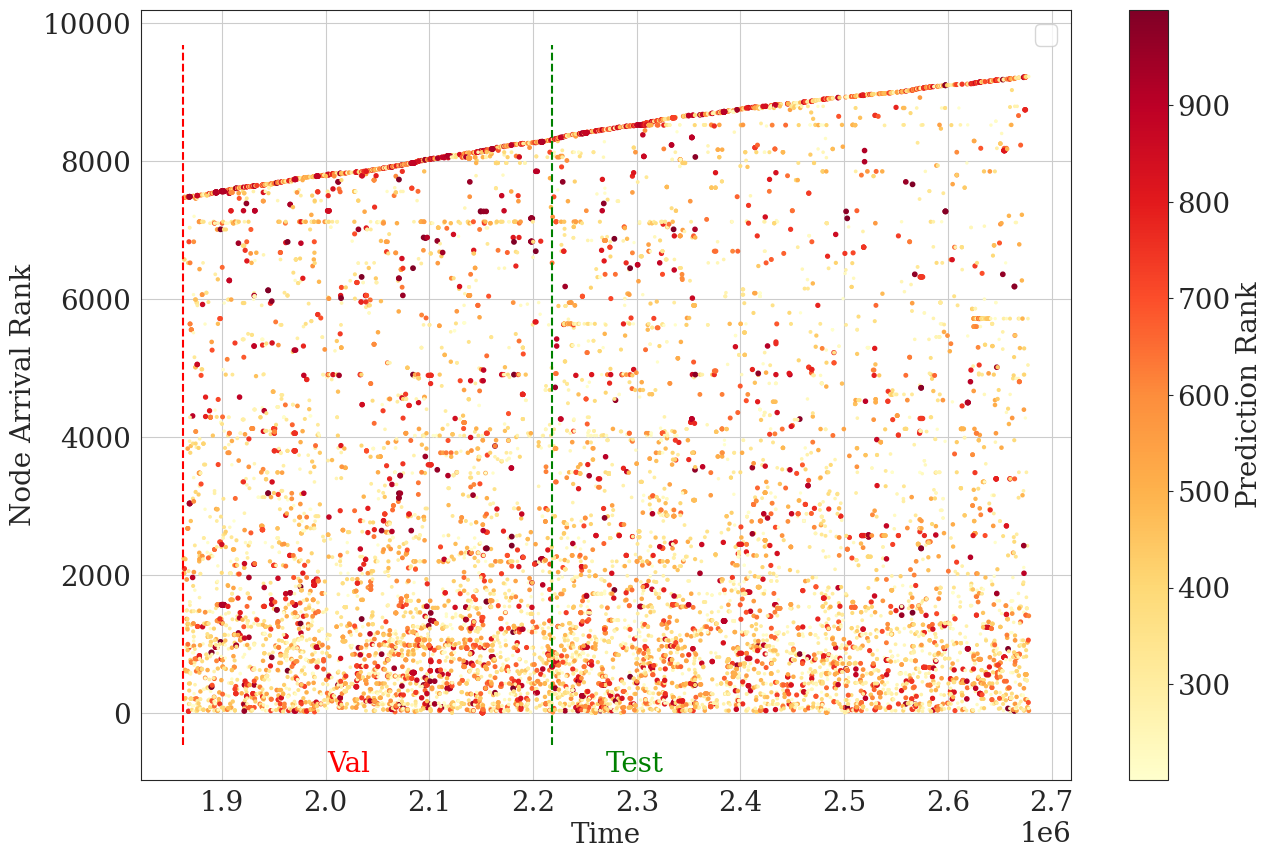

In [50]:
from stats import temporal_node_traffic

shared_utils.set_theme(fontsize=20)
fig, ax = plt.subplots(1, figsize=(15, 10))

df = events.copy()

df = df[df.rank_opt > 200]

ax.scatter(
    x=df["t"],
    y=df["src_arrival_rank"],
    c=df["rank_opt"],
    cmap=color_scheme,
    s=df["rank_opt"] / 100,
)
ax.scatter(
    x=df["t"],
    y=df["dst_arrival_rank"],
    c=df["rank_opt"],
    cmap=color_scheme,
    s=df["rank_opt"] / 100,
)

ylim = plt.ylim()
plt.vlines(
    events.val_time,
    ymin=ylim[0],
    ymax=ylim[1],
    color="red",
    linestyles="dashed",
)


plt.vlines(
    events.test_time,
    ymin=ylim[0],
    ymax=ylim[1],
    color="green",
    linestyles="dashed",
)
ypos = 0.01

plt.annotate(
    "Val",
    xy=(0.2, ypos),
    xytext=(0.2, ypos),
    xycoords="axes fraction",
    fontsize=20,
    color="red",
)
plt.annotate(
    "Test",
    xy=(0.5, ypos),
    xytext=(0.5, ypos),
    xycoords="axes fraction",
    fontsize=20,
    color="green",
)
plt.legend()
plt.ylabel("Edge Arrival Rank")
plt.xlabel("Time")


fig.colorbar(im, ax=ax, label="Prediction Rank")
plt.xlabel("Time")
plt.ylabel("Node Arrival Rank")

## Compare the Prediction Rank with the Destination Node's degree 

In [52]:
df_valtest

,split,src,dst,t,label,idx,edge_key,edge_degree,edge_arrival_rank,src_arrival_rank,dst_arrival_rank,src_degree,dst_degree,t_scaled,y_pred,rank_opt,rank_pes
0,val,5300,9110,1862653.0,0.0,110233,82997400,28.0,10425,6181,6182,28.0,36.0,0.695442,0.999376,0.0,0.0
1,val,117,8991,1862659.0,0.0,110234,80838198,5.0,10397,215,4089,34.0,83.0,0.695444,0.996401,25.0,25.0
2,val,345,8461,1862666.0,0.0,110235,71588866,68.0,435,582,571,127.0,130.0,0.695447,0.988543,11.0,11.0
3,val,286,8866,1862671.0,0.0,110236,78606242,66.0,3218,499,2674,534.0,83.0,0.695449,0.999888,9.0,9.0
4,val,345,8461,1862680.0,0.0,110237,71588866,69.0,435,582,571,128.0,131.0,0.695452,0.988543,11.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47237,test,2004,8860,2678155.0,0.0,157470,78501604,129.0,3166,2635,2636,217.0,130.0,0.999919,0.999970,4.0,4.0
47238,test,3763,9026,2678158.0,0.0,157471,81472439,226.0,6725,4560,4561,226.0,229.0,0.999920,0.999997,3.0,3.0
47239,test,2400,8723,2678293.0,0.0,157472,76093129,82.0,3946,3077,1655,82.0,208.0,0.999970,0.999714,2.0,2.0
47240,test,7480,9148,2678333.0,0.0,157473,83693384,76.0,16124,8465,6752,76.0,93.0,0.999985,0.999942,5.0,5.0


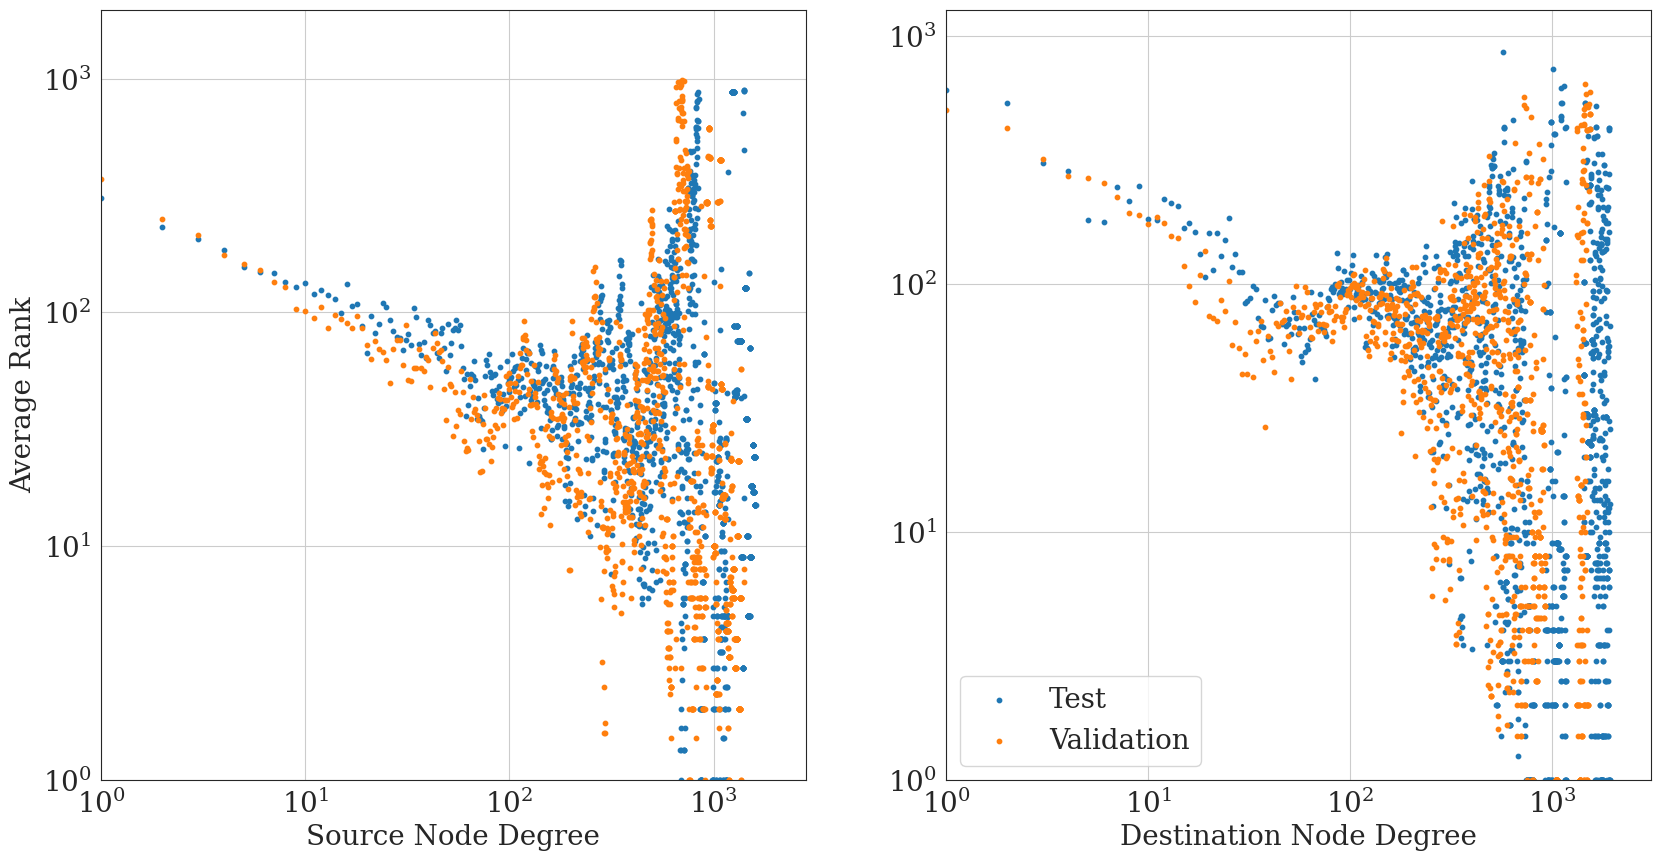

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for ax, key, name in zip(axs, ["src_degree", "dst_degree"], ["Source", "Destination"]):
    df_valtest = events.loc[["val", "test"]].reset_index()

    for split_name, split in df_valtest.groupby("split"):
        split_ranks = split.groupby(key)["rank_opt"].mean()

        loglogplot(split_ranks, ax, label=split_name)
    ax.set_xlabel(f"{name} Node Degree")
    ax.set_ylabel("Average Rank") if ax == axs[0] else None


plt.legend(labels=["Test", "Validation"])